# Dados

### 2. Ingestão



A etapa de **ingestão** é responsável por trazer os dados transacionais para um ambiente analítico. Basicamente, o objetivo é manter os dados no formato mais próximo do original, sem realizar transformações no conteúdo ou na estrutura (*schema*). Por exemplo, se eu estou lidando com dados de uma API web que utiliza o formato REST (*representational state transfer*), esses dados são entregues e armazenados no formato JSON.

> **Persistir os dados no seu formato original tem várias vantagens, como a possibilidade de reprocessamento futuro.**

A ingestão pode ser conduzida de duas formas:

 - **Batch**: Onde blocos de dados são ingeridos em intervalos de tempo bem definidos, como horas ou dias.
 - **Streaming**: Onde os dados são ingeridos em tempo real, conforme são produzidos e disponibilizados.

Neste projeto, as mensagens capturadas pelo bot do Telegram são entregues no formato JSON através da API web de bots. Como o Telegram mantém as mensagens por apenas 24 horas, vamor usar a ingestão via streaming. Para isso, implementei um webhook (gancho web), que redireciona automaticamente as mensagens para outra API web.


Para isso, utilizei um serviço da AWS que fornece uma API web para receber os dados redirecionados: o `AWS API Gateway` (veja a documentação [aqui](https://docs.aws.amazon.com/pt_br/apigateway/latest/developerguide/welcome.html)). O `AWS API Gateway` tem a capacidade de redirecionar os dados recebidos para outros serviços da AWS. Então, conectei-o ao `AWS Lambda`, que armazena os dados em seu formato original (JSON) em um bucket do `AWS S3`.

> **Sistemas que reagem a eventos são conhecidos como *event-driven*.**

Portanto, as etapas necessárias foram:

 - Criar um *bucket* no `AWS S3`;
 - Criar uma função no `AWS Lambda`;
 - Criar uma API *web* no `AWS API Gateway`;
 - Configurar o *webhook* da API de *bots* do **Telegram**.

### **2.1. AWS S3**

Na etapa de **ingestão**, o `AWS S3` é usado para armazenar as mensagens capturadas pelo bot do Telegram no seu formato original (JSON). Para isso, criei um bucket no S3. Seguindo um padrão, adicionei o sufixo `-raw` ao nome do bucket para manter a consistência (essa nomenclatura será usada para todos os serviços dessa camada).

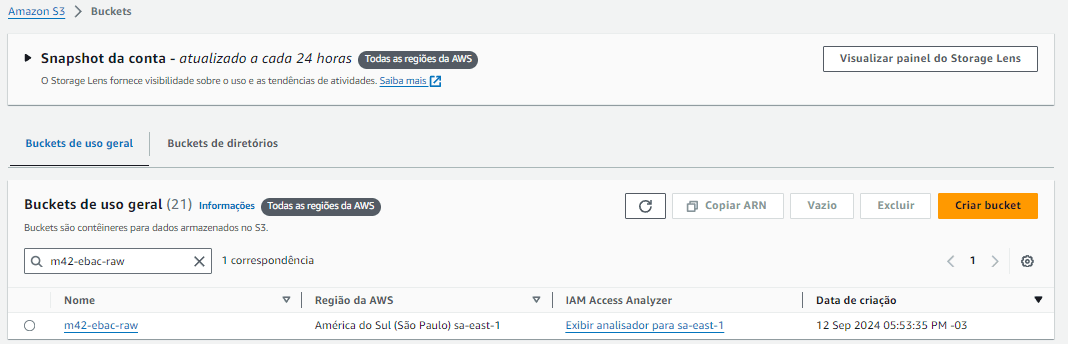


> **Nota**: um `data lake` é o nome dado a um repositório de um grande volume dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: *raw* e *enriched* ou *bronze*, *silver* e *gold*.

### **2.2. AWS Lambda**

Na etapa de **ingestão**, o `AWS Lambda` é responsável por persistir ativamente as mensagens capturadas pelo bot do **Telegram** em um *bucket* do `AWS S3`. Para isso, criei uma função que realiza as seguintes operações:

 - Recebe a mensagem no parâmetro `event`;
 - Verifica se a mensagem tem origem no grupo do **Telegram** correto;
 - Persiste a mensagem no formato JSON no *bucket* do `AWS S3`;
 - Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de *bots* do **Telegram**.

> **Nota**: No **Telegram**, restringimos a opção de adicionar o *bot* a grupos, contudo, ainda é possível iniciar uma conversa em um *chat* privado.

Aqui está o código da função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

 - **Variáveis de ambiente**

No código, é preciso configurar duas variáveis de ambiente: `AWS_S3_BUCKET`, que deve conter o nome do *bucket* do `AWS S3`, e `TELEGRAM_CHAT_ID`, que deve ter o ID do *chat* do grupo do **Telegram**. Essas variáveis podem ser adicionadas acessando as configurações da função no console do `AWS Lambda` e navegando até a seção de variáveis de ambiente.

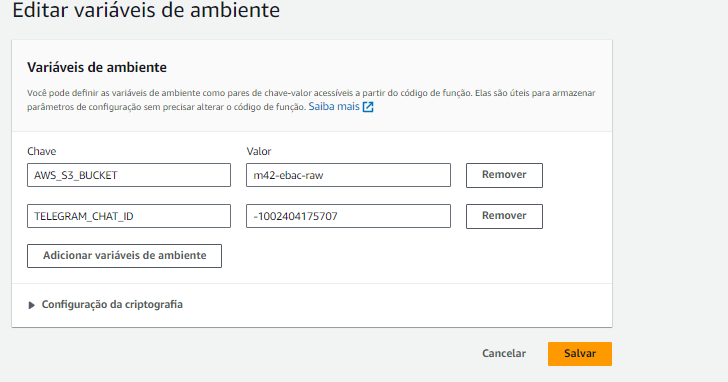

> **Nota: Variáveis de ambiente são excelentes formas de armazenar informações sensíveis.**

 - **Permissão**

Além disso, é necessário conceder permissão de escrita no bucket do AWS S3 para a função do AWS Lambda. Isso é feito configurando as atribuições no AWS IAM. Para fins educativos, adicionaremos a permissão `AmazonS3FullAccess`. No entanto, na prática, o ideal é selecionar os buckets corretos e configurar configurações mais restritivas para garantir a segurança.

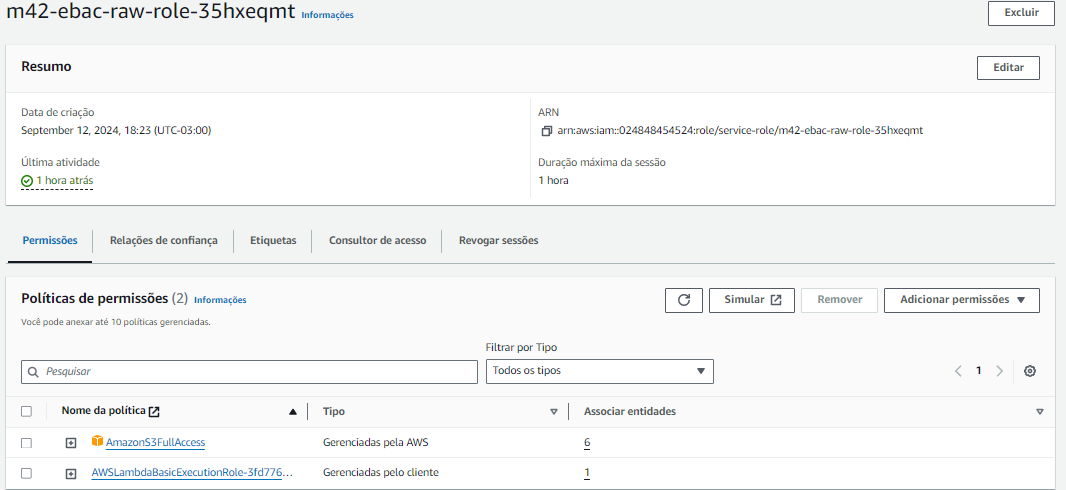







Para testar, criaremos o conteudo de teste com o valor da própria mensagem aquilo que esta dentro da chave `result`

In [ ]:
{
  "update_id": 967743620,
  "message": {
    "message_id": 4,
    "from": {
      "id": 6389278058,
      "is_bot": false,
      "first_name": "Denise",
      "last_name": "Schuartz",
      "language_code": "en"
    },
    "chat": {
      "id": -1002404175707,
      "title": "M42 EBAC Group",
      "type": "supergroup"
    },
    "date": 1726169310,
    "text": "Ola, Mundo!"
  }
}

Noosa função Lambda está retornando um `200 OK` status. Isso sugere que a função está sendo executada com sucesso.

Ao atualizarmos o nosso bucket S3, observámos que a função capturou as mensagens e as armazenou corretamente. Dentro do bucket, foi criada automaticamente uma pasta chamada "telegram". No seu interior, encontra-se um diretório com o nome "context_date=[data de hoje]", que contém um ficheiro no formato JSON, representando a mensagem que foi enviada para o grupo.

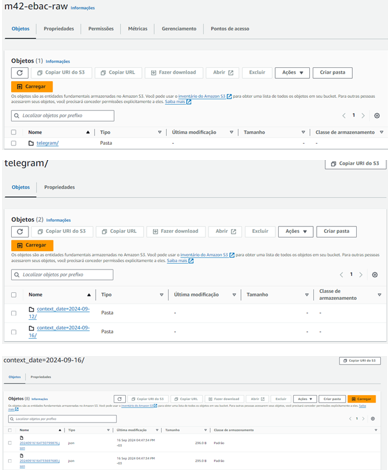

### **2.3. AWS API Gateway**

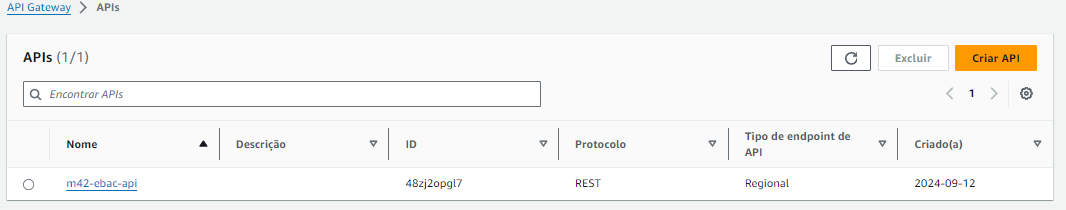

Na etapa de **ingestão**, o `AWS API Gateway` é responsável por receber as mensagens capturadas pelo *bot* do **Telegram**, que são enviadas via *webhook*, e por iniciar uma função do `AWS Lambda`, passando o conteúdo da mensagem no seu parâmetro *event*. Para implementar isso, eu criei uma API e a configurei como gatilho da função do `AWS Lambda` com os seguintes passos:

 - Acesse o serviço e selecione: *Create API* -> *REST API*;
 - Insira um nome para a API, utilizando o sufixo `-api` como padrão;
 - Selecione: *Actions* -> *Create Method* -> *POST*;
 - Na tela de *configuração*:
  - Selecione *Integration type* igual a *Lambda Function*;
  - Habilite a opção *Use Lambda Proxy integration*;
  - Procure pelo nome da função do `AWS Lambda` que foi criada anteriormente.

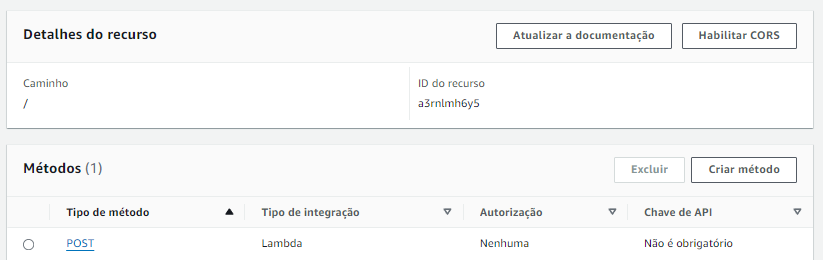

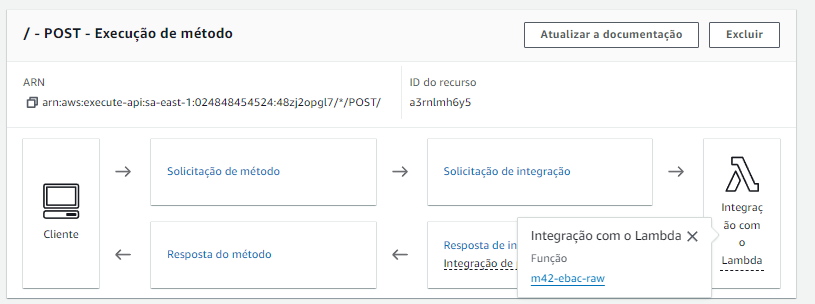



Eu testei a integração com a função do `AWS Lambda` usando a ferramenta de testes disponível no AWS API Gateway. Após verificar que tudo estava funcionando corretamente, fiz a implantação da API e obtive o seu endereço *web*:

 - Selecione: *Actions* -> *Deploy API*;
 - Escolha *New Stage* para o *Deployment stage*;
 - Adicione *dev* como `Stage name`.

Assim que retornamos ao nosso bucket, verificamos a geração de um novo arquivo (20240916185039765324.json) como resultado da integração. Tudo indica que o API Gateway está corretamente conectado e funcionando como esperado.

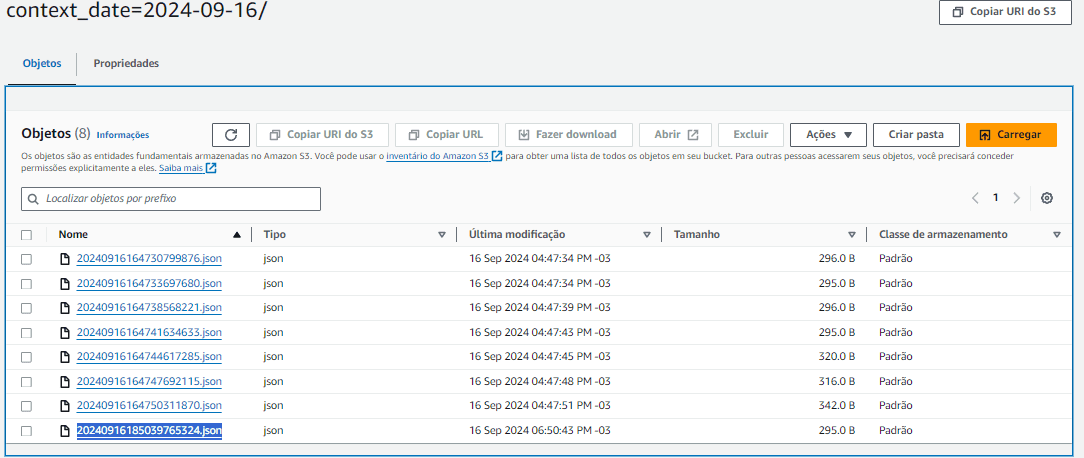

A última etapa envolve fazer o deploy da nossa API, ou seja, a implantação para que ela esteja acessível via web. O resultado desse processo é a geração de uma URL, que utilizaremos para configurar o *webhook* do Telegram. Isso permitirá que os dados sejam enviados diretamente para o `AWS API Gateway`, que, por sua vez, os encaminhará para a função do `AWS Lambda`. O `Lambda` processará os dados e os armazenará no `AWS S3`.

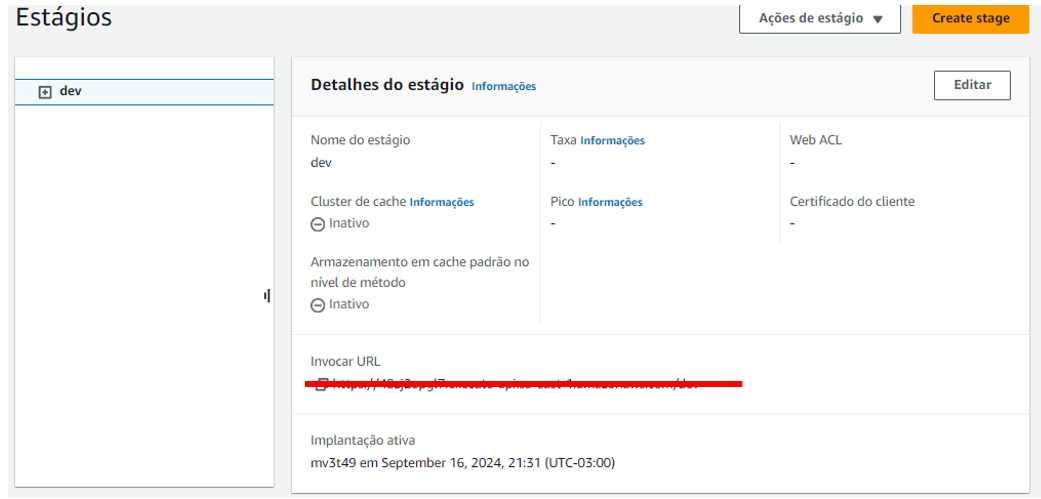

Copie o a `url` gerada na variável `aws_api_gateway_url`.

In [ ]:
aws_api_gateway_url = getpass()

··········


### **2.4. Telegram**




Agora vamos voltar ao Telegram e criar de fato o *webhook*. O *webhook* é basicamente uma forma de redirecionar requisições de uma API para outra, o que é exatamente o que faremos aqui. Temos nossa API de *bots* do Telegram e, para conectar as duas, vamos configurar o *webhook* para que todas as mensagens do backend do Telegram sejam enviadas automaticamente para a API que acabamos de criar.

Essa configuração vai permitir que, toda vez que o bot do Telegram receber uma mensagem, ela seja redirecionada para nossa API, que, em seguida, a encaminha para o `AWS Lambda`, responsável por processar e armazenar os dados no `AWS S3`.

Assim, garantimos que o fluxo de mensagens do Telegram será capturado e tratado em tempo real através desse *webhook*.

 - **setWebhook**

O método `setWebhook` configura o redirecionamento das mensagens captadas pelo *bot* para o endereço *web* do paramametro `url`.

> **Nota**: os métodos `getUpdates` e `setWebhook` são mutualmente exclusivos, ou seja, enquanto o *webhook* estiver ativo, o método `getUpdates` não funcionará. Para desativar o *webhook*, basta utilizar o método `deleteWebhook`.

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


 - **getWebhookInfo**

O método `getWebhookInfo` retorna as informações sobre o *webhook* configurado.

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://48zj2opgl7.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 6,
    "max_connections": 40,
    "ip_address": "54.232.28.47"
  }
}


Vamos limpar os arquivos e objetos do nosso *bucket* no `S3`, enviar novas mensagens para o **Telegram** e verificar se conseguimos capturar os dados corretamente. Isso nos permitirá testar o fluxo completo, desde o recebimento das mensagens pelo bot até o armazenamento no `S3`.

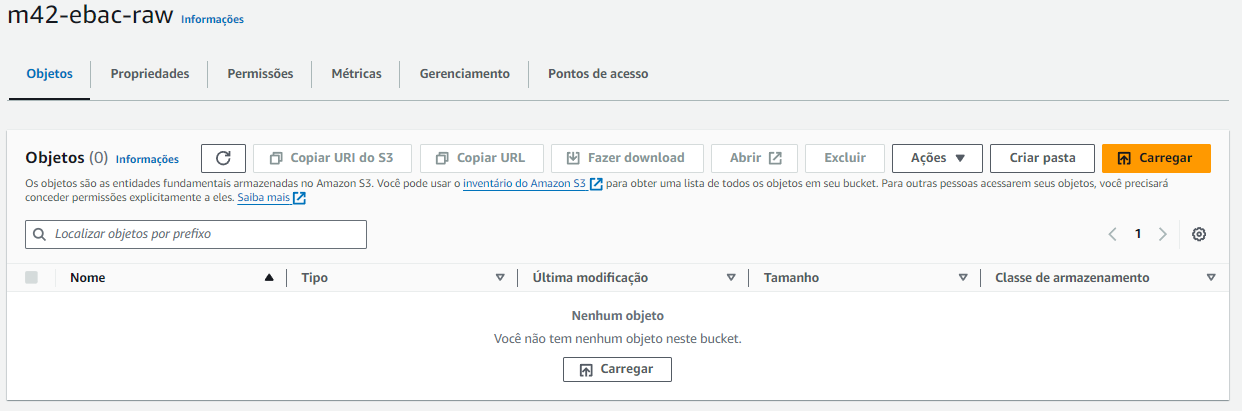

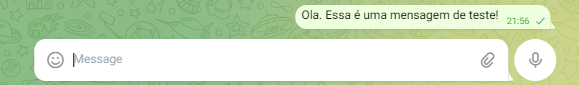

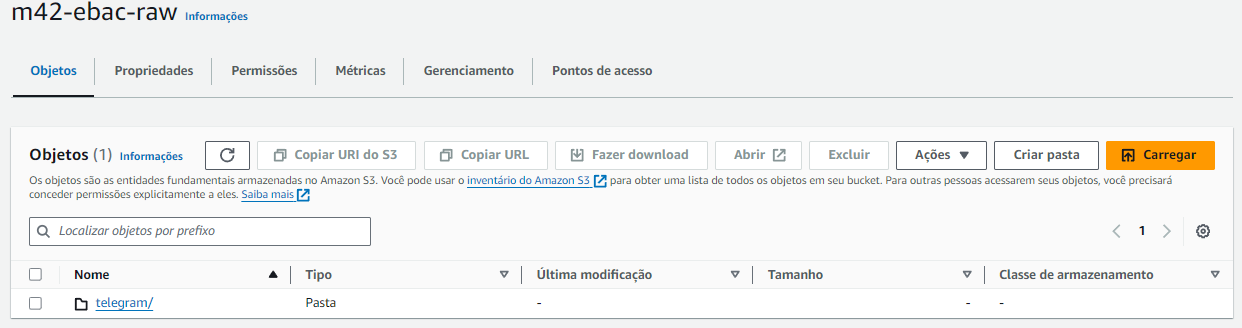

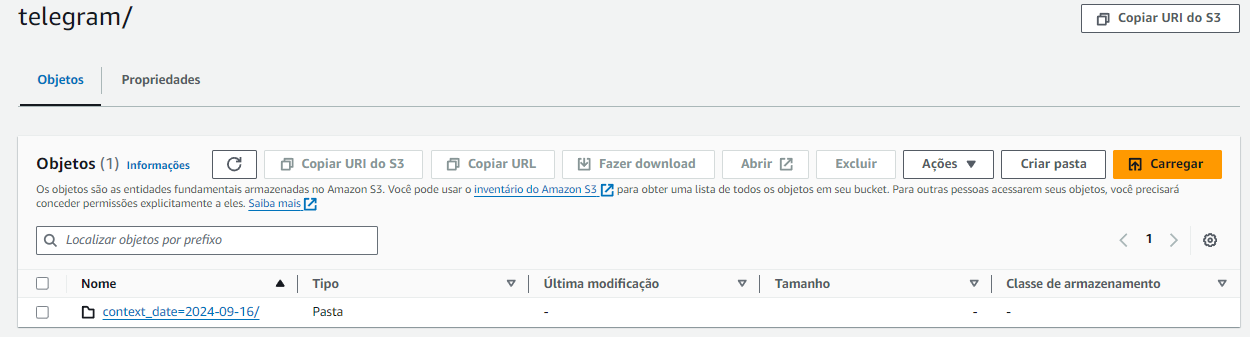

Pronto! Com isso, concluímos a camada de ingestão e garantimos que todas as mensagens enviadas no chat do grupo do Telegram estão sendo capturadas e armazenadas corretamente no ambiente analítico. As mensagens são primeiramente armazenadas no *bucket* da camada crua, concluindo assim a nossa configuração inicial.